In [1]:
import glob
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib

# stats
from scipy import linalg, ndimage, stats
from scipy.stats import norm


# nifti handling
from nilearn.input_data import NiftiMasker
from nilearn import decoding
from nilearn.masking import apply_mask, intersect_masks
from nilearn import image
from nilearn.image import new_img_like, load_img, get_data, concat_imgs, mean_img,math_img
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img
from nilearn import surface
# nilearn mask:
from nilearn.datasets import load_mni152_gm_mask,load_mni152_wm_mask,fetch_surf_fsaverage

from nilearn import surface
#fsaverage = fetch_surf_fsaverage('fsaverage')
fsaverage = fetch_surf_fsaverage()



# plotting modules
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_prob_atlas, plot_img, show
from nilearn.image import threshold_img
from nilearn.plotting import plot_roi


import warnings

/Users/yiyuwang/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
calculate = True

In [61]:
base_dir = '/Users/yiyuwang/Dropbox/Projects/AffVids_analysis/'


res_dir = base_dir + 'results/searchlight_lassopcr_alpha001_subjective_visualreg_fixedcv_20211202/'
#res_dir = '/Users/yiyuwang/Downloads/searchlight_lassopcr_alpha001_subjective_visualreg_fixedcv_20211202/'
permutation_dir = '/Users/yiyuwang/Downloads/searchlight_lassopcr_alpha001_permutation_subjective_visualreg_shuffled_train_fixedcv/'
#permutation_dir = '/Users/yiyuwang/Downloads/searchlight_lassopcr_alpha001_permutation_subjective_visualreg_shuffled_train_fixedcv_3mm_20211201/'

mask_dir = base_dir + 'masks/'
bg_img = mask_dir + 'MNI152_T1_1mm_brain.nii.gz'

color_padding_three =['#1f77b4', '#9edae5','#D3D3D3','#D3D3D3']
my_color_three = ['#1f77b4', '#9edae5', '#EF2D2E']
my_cmap_three = matplotlib.colors.ListedColormap(color_padding_three + my_color_three)


#my_color_seven = ["#61a3d5","#fdf85e","#9bdf49","#e687d9","#fdc028","#9af6e7","#FE4730"]
my_color_seven = ['#33a02c', '#6a3d9a', '#ff7f00', '#b2df8a', '#FDF85E', '#DA83F8', '#EF2D2E']
my_color_seven = ['#1f77b4', '#1f77b4','#1f77b4', '#9edae5', '#9edae5', '#9edae5', '#EF2D2E']
color_padding = ["#fd7f6f", "#7eb0d5", "#ffee65", "#b2e061", "#bd7ebe", "#ffb55a","#8bd3c7",'#D3D3D3']
my_cmap_seven = matplotlib.colors.ListedColormap(color_padding + my_color_seven)


# surface plot interpolation function:
def custom_function(vertices):
    return vertices[0]


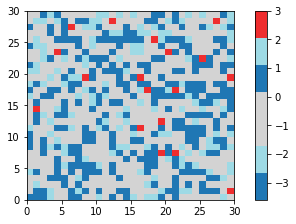

In [4]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmax=3)
        fig.colorbar(psm, ax=ax)
    plt.show()
    
plot_examples([my_cmap_three])    

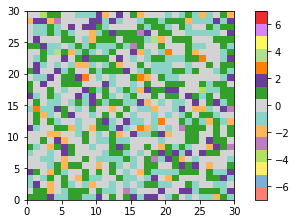

In [5]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-7, vmax=7)
        fig.colorbar(psm, ax=ax)
    plt.show()
    
plot_examples([my_cmap_seven])

# threshold p = 0.1

# Situation General Model:

In [6]:
permutation_test_res_dir = res_dir + 'permutation_test_01/'
if calculate:
    
    SG_H = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Heights_significant_pearsonr_fwe.nii.gz')
    SG_SO = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Social_significant_pearsonr_fwe.nii.gz')
    SG_SP = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Spiders_significant_pearsonr_fwe.nii.gz')
    SG_SG = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Situation_General_significant_pearsonr_fwe.nii.gz')


    SG_H_mask = math_img('img != 0', img = SG_H)
    SG_SO_mask = math_img('img != 0', img = SG_SO)
    SG_SP_mask = math_img('img != 0', img = SG_SP)
    SG_SG_mask = math_img('img != 0', img = SG_SG)

    SGSG_SGH = intersect_masks([SG_H_mask, SG_SG_mask],threshold=1)
    SGSG_SGSO = intersect_masks([SG_SO_mask, SG_SG_mask],threshold=1)
    SGSG_SGSP = intersect_masks([SG_SP_mask, SG_SG_mask],threshold=1)

    overlay = math_img('img1 + img2 + img3', img1=SGSG_SGH, img2=SGSG_SGSO, img3=SGSG_SGSP)
    nib.save(overlay, permutation_test_res_dir + 'SGSG_breakdown_overlay.nii.gz')


    SGSG_SGH = intersect_masks([SG_H_mask, SG_SG_mask],threshold=1)
    SGSG_SGSO = intersect_masks([SG_SO_mask, SG_SG_mask],threshold=1)
    SGSG_SGSP = intersect_masks([SG_SP_mask, SG_SG_mask],threshold=1)

    SGSO_only =  math_img('img * 2', img = SGSG_SGSO)
    SGSP_only =  math_img('img * 4', img = SGSG_SGSP)

    overlay_by_sit = math_img('img1 + img2 + img3', img1=SGSG_SGH, img2=SGSO_only, img3=SGSP_only)
    
    # swtich value 3 and 4 for better visualization:
    overlay_by_sit_data = overlay_by_sit.get_fdata()
    three_idx = np.where(overlay_by_sit_data ==3)
    four_idx = np.where(overlay_by_sit_data ==4)
    overlay_by_sit_data[four_idx] = 3
    overlay_by_sit_data[three_idx] = 4
    overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
    nib.save(overlay_by_sit, permutation_test_res_dir + 'SGSG_breakdown_overlay_bySit.nii.gz')
else:
    overlay =nib.load(permutation_test_res_dir + 'SGSG_breakdown_overlay.nii.gz')
    overlay_by_sit = nib.load(permutation_test_res_dir + 'SGSG_breakdown_overlay_bySit.nii.gz')


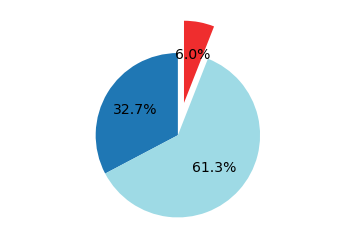

In [7]:

overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent', 'Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [8]:
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)

texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)



sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1

np.unique(sum_texture_right)

array([0, 1, 2, 3])

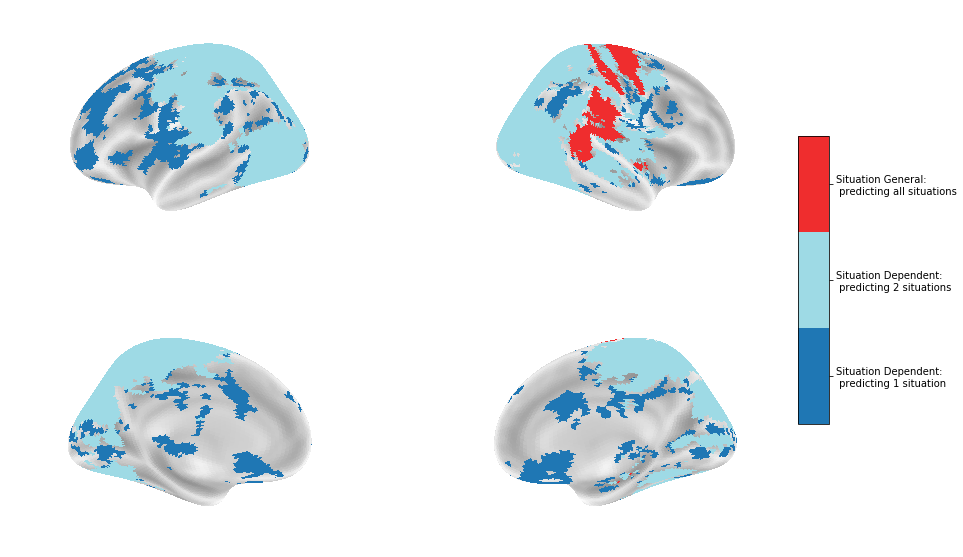

In [9]:
# plot the results:
vmin=0.99
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left,sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left, axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=-3, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
# cbar_ax.set_yticklabels(["Situation Dependent", "Situation Dependent", "Situation General"])
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


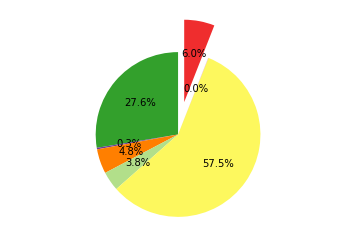

In [10]:
# pie chart - break down by situation:
# overlay_by_sit_data = overlay_by_sit.get_fdata()

H_only = np.sum(overlay_by_sit_data==1)
SO_only = np.sum(overlay_by_sit_data==2)
SP_only = np.sum(overlay_by_sit_data==3)
HSO = np.sum(overlay_by_sit_data==4)
HSP = np.sum(overlay_by_sit_data==5)
SOSP = np.sum(overlay_by_sit_data==6)
seven =np.sum(overlay_by_sit_data==7)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = 'Heights Only', 'Social only', 'Spiders only', 'Heights +Social', 'Heights + Spiders', 'Social + Spiders', 'Situation General'
labels = ' ', ' ', ' ', ' ', ' ', ' ', ' '
sizes = [H_only, SO_only, SP_only, HSO, HSP, SOSP, seven]
explode = (0, 0, 0, 0, 0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=my_color_seven)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [11]:
SGH_only =  math_img('img1 == 1', img1 = overlay_by_sit)
SGSO_only =  math_img('img1 == 2', img1 = overlay_by_sit)
SGSP_only =  math_img('img1 == 3', img1 = overlay_by_sit)

SGH_SGSO = math_img('img1==4', img1 = overlay_by_sit)
SGH_SGSP = math_img('img1==5', img1 = overlay_by_sit)
SGSO_SGSP = math_img('img1==6', img1 = overlay_by_sit)

seven = math_img('img1==7', img1 = overlay_by_sit)
texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(SGH_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(SGH_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)

texture_right4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_right, interpolation='nearest')
texture_left4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_left, interpolation='nearest')
texture_right4 = np.where(texture_right4>texture_threshold, 4, 0)
texture_left4 = np.where(texture_left4>texture_threshold, 4, 0)

texture_right5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right5 = np.where(texture_right5>texture_threshold, 5, 0)
texture_left5 = np.where(texture_left5>texture_threshold, 5, 0)

texture_right6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right6 = np.where(texture_right6>texture_threshold, 6, 0)
texture_left6 = np.where(texture_left6>texture_threshold, 6, 0)


texture_right7 = surface.vol_to_surf(seven, fsaverage.pial_right, interpolation='nearest')
texture_left7 = surface.vol_to_surf(seven, fsaverage.pial_left, interpolation='nearest')
texture_right7 = np.where(texture_right7>texture_threshold, 7, 0)
texture_left7 = np.where(texture_left7>texture_threshold, 7, 0)


sum_texture_right = texture_right7 + texture_right6 + texture_right5 + texture_right4 + texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left7 + texture_left6 + texture_left5 + texture_left4 + texture_left3 + texture_left2 + texture_left1

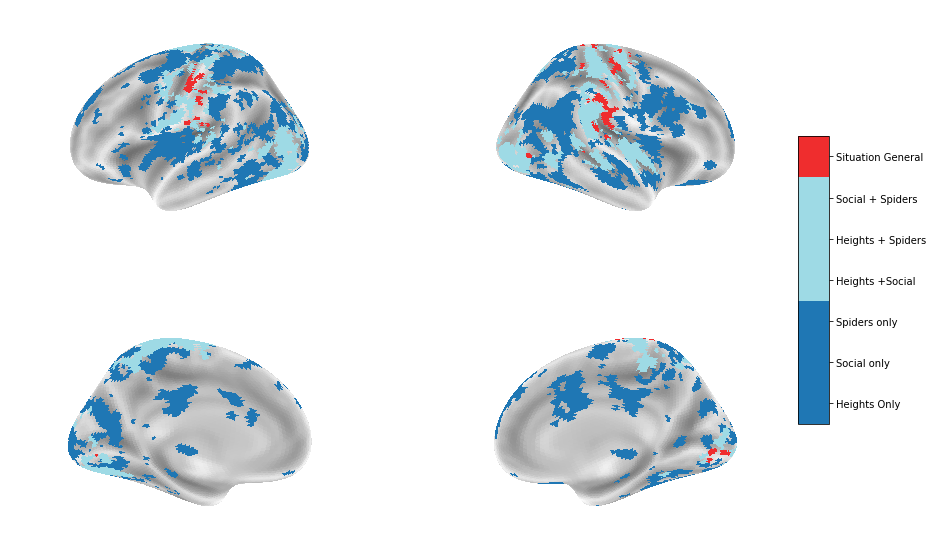

In [62]:
labels =['Heights Only', 'Social only', 'Spiders only', 'Heights +Social', 'Heights + Spiders', 'Social + Spiders', 'Situation General']
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99, vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=-7, cbar_vmax=7,bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.6, inflate=True)

cmap = matplotlib.colors.ListedColormap(my_color_seven)
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(labels)
plt.show()

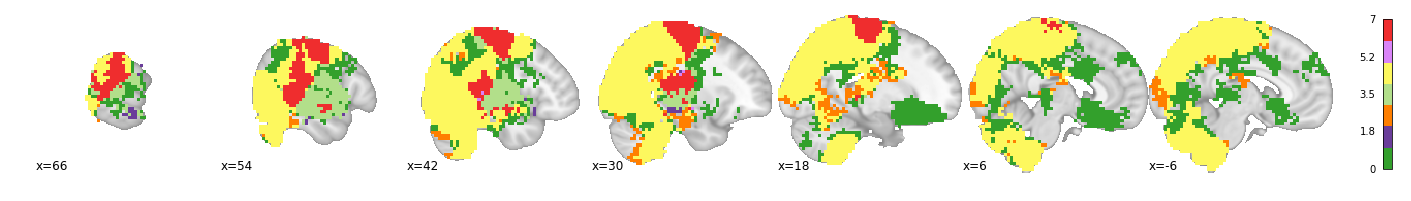

In [13]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)

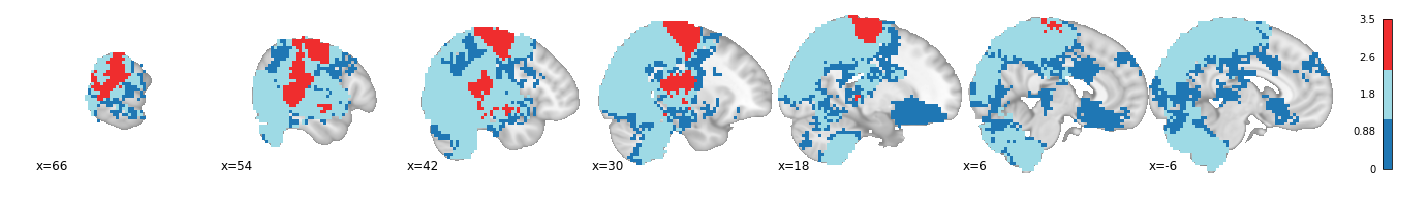

In [14]:
plotting.plot_stat_map(overlay, cmap=my_cmap_three, display_mode='x', vmax=3.5,bg_img=bg_img,black_bg=False)

# Situation Dependent Model

In [15]:
# overlay by situation-depdent models:
if calculate:
    HH = nib.load(permutation_test_res_dir + f'train_Heights_test_Heights_significant_pearsonr_fwe.nii.gz')
    SOSO = nib.load(permutation_test_res_dir + f'train_Social_test_Social_significant_pearsonr_fwe.nii.gz')
    SPSP = nib.load(permutation_test_res_dir + f'train_Spiders_test_Spiders_significant_pearsonr_fwe.nii.gz')

    HH_mask = math_img('img != 0', img = HH)
    SOSO_mask = math_img('img != 0', img = SOSO)
    SPSP_mask = math_img('img != 0', img = SPSP)

    overlay = math_img('img1 + img2 + img3', img1=HH_mask, img2=SOSO_mask, img3=SPSP_mask)
    nib.save(overlay, permutation_test_res_dir + 'SS_overlay.nii.gz')


    SO_only =  math_img('img * 2', img = SOSO_mask)
    SP_only =  math_img('img * 4', img = SPSP_mask)

    overlay_by_sit = math_img('img1 + img2 + img3', img1=HH_mask, img2=SO_only, img3=SP_only)
    # swtich value 3 and 4 for better visualization:
    overlay_by_sit_data = overlay_by_sit.get_fdata()
    three_idx = np.where(overlay_by_sit_data ==3)
    four_idx = np.where(overlay_by_sit_data ==4)
    overlay_by_sit_data[four_idx] = 3
    overlay_by_sit_data[three_idx] = 4
    overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
    nib.save(overlay_by_sit, permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')
else:
    overlay = nib.load(permutation_test_res_dir + 'SS_overlay.nii.gz')
    overlay_by_sit = nib.load(permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')

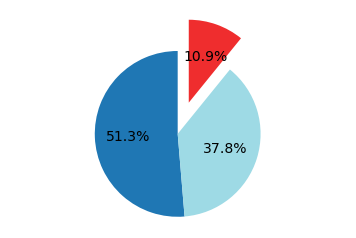

In [16]:
overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent', 'Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

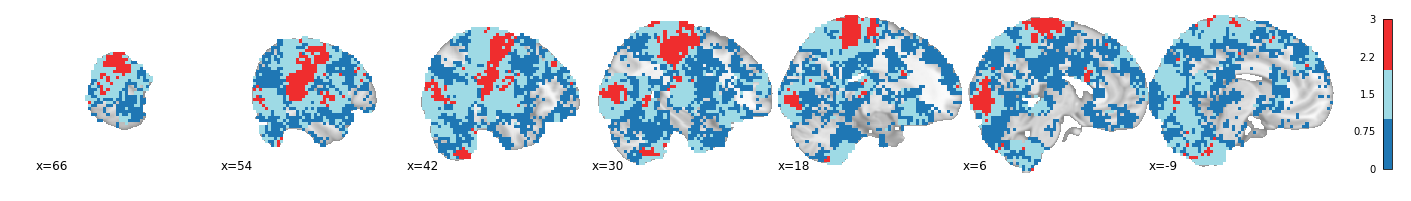

In [17]:
plotting.plot_stat_map(overlay, cmap=my_cmap_three, display_mode='x', vmax=3,bg_img=bg_img,black_bg=False)

In [18]:
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)


texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)



sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1

np.unique(sum_texture_right)

array([0, 1, 2, 3])

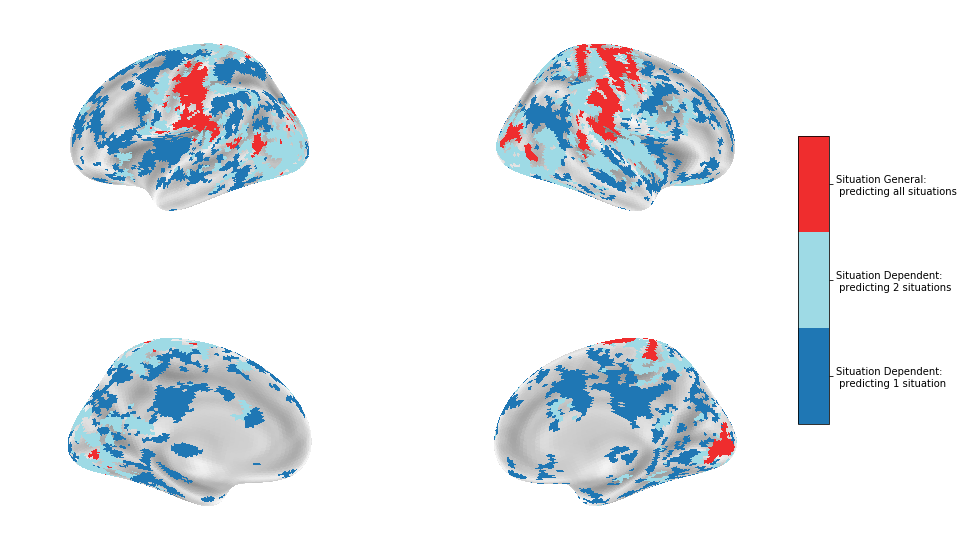

In [19]:
# plot the results:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=-3, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


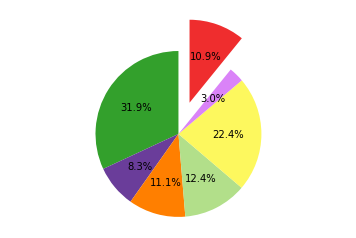

In [20]:
# pie chart - break down by situation:
overlay_by_sit_data = overlay_by_sit.get_fdata()

H_only = np.sum(overlay_by_sit_data==1)
SO_only = np.sum(overlay_by_sit_data==2)
SP_only = np.sum(overlay_by_sit_data==3)
HSO = np.sum(overlay_by_sit_data==4)
HSP = np.sum(overlay_by_sit_data==5)
SOSP = np.sum(overlay_by_sit_data==6)
seven =np.sum(overlay_by_sit_data==7)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Heights Only', 'Social only', 'Spiders only', 'Heights +Social', 'Heights + Spiders', 'Social + Spiders', 'Situation General']
labels = ' ', ' ', ' ', ' ', ' ', ' ', ' '
sizes = [H_only, SO_only, SP_only, HSO, HSP, SOSP, seven]
explode = (0, 0, 0, 0, 0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=my_color_seven)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

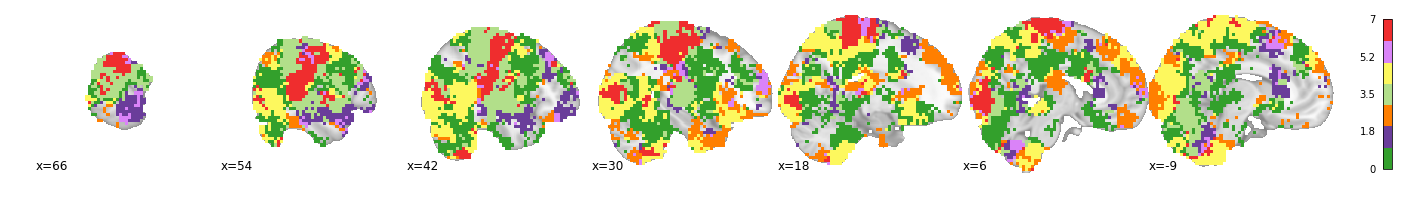

In [21]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)

In [22]:
SGH_only =  math_img('img1 == 1', img1 = overlay_by_sit)
SGSO_only =  math_img('img1 == 2', img1 = overlay_by_sit)
SGSP_only =  math_img('img1 == 3', img1 = overlay_by_sit)

SGH_SGSO = math_img('img1==4', img1 = overlay_by_sit)
SGH_SGSP = math_img('img1==5', img1 = overlay_by_sit)
SGSO_SGSP = math_img('img1==6', img1 = overlay_by_sit)

seven = math_img('img1==7', img1 = overlay_by_sit)
texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(SGH_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(SGH_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)

texture_right4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_right, interpolation='nearest')
texture_left4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_left, interpolation='nearest')
texture_right4 = np.where(texture_right4>texture_threshold, 4, 0)
texture_left4 = np.where(texture_left4>texture_threshold, 4, 0)

texture_right5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right5 = np.where(texture_right5>texture_threshold, 5, 0)
texture_left5 = np.where(texture_left5>texture_threshold, 5, 0)

texture_right6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right6 = np.where(texture_right6>texture_threshold, 6, 0)
texture_left6 = np.where(texture_left6>texture_threshold, 6, 0)


texture_right7 = surface.vol_to_surf(seven, fsaverage.pial_right, interpolation='nearest')
texture_left7 = surface.vol_to_surf(seven, fsaverage.pial_left, interpolation='nearest')
texture_right7 = np.where(texture_right7>texture_threshold, 7, 0)
texture_left7 = np.where(texture_left7>texture_threshold, 7, 0)


sum_texture_right = texture_right7 + texture_right6 + texture_right5 + texture_right4 + texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left7 + texture_left6 + texture_left5 + texture_left4 + texture_left3 + texture_left2 + texture_left1

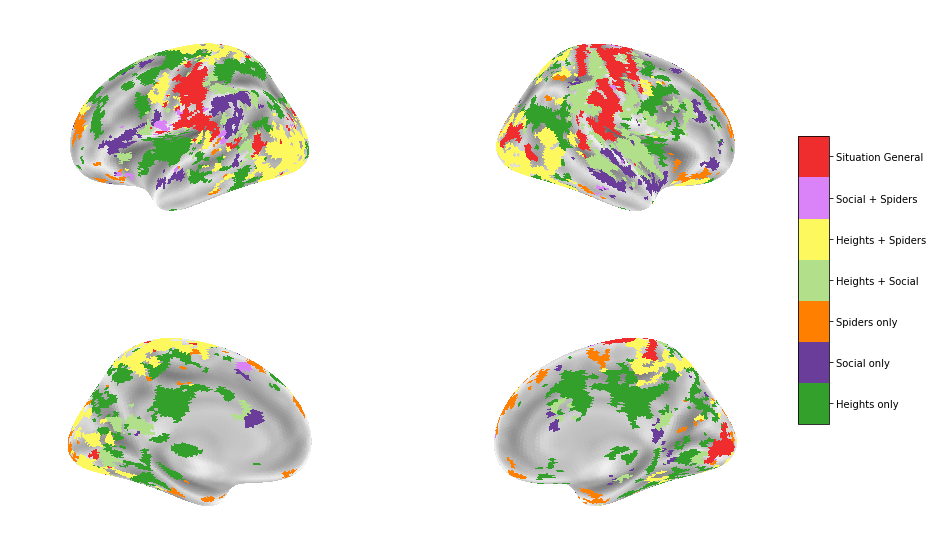

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99, vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=-7, cbar_vmax=7,bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.6, inflate=True)

cmap = matplotlib.colors.ListedColormap(my_color_seven)
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(["Heights only", "Social only", "Spiders only", "Heights + Social", "Heights + Spiders", "Social + Spiders", "Situation General"])
plt.show()

# threshold fwe p = 0.05

# Situation General

In [24]:
permutation_test_res_dir = res_dir + 'permutation_test/'
if calculate:
    SG_H = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Heights_significant_pearsonr_fwe.nii.gz')
    SG_SO = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Social_significant_pearsonr_fwe.nii.gz')
    SG_SP = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Spiders_significant_pearsonr_fwe.nii.gz')
    SG_SG = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Situation_General_significant_pearsonr_fwe.nii.gz')


    SG_H_mask = math_img('img != 0', img = SG_H)
    SG_SO_mask = math_img('img != 0', img = SG_SO)
    SG_SP_mask = math_img('img != 0', img = SG_SP)
    SG_SG_mask = math_img('img != 0', img = SG_SG)

    SGSG_SGH = intersect_masks([SG_H_mask, SG_SG_mask],threshold=1)
    SGSG_SGSO = intersect_masks([SG_SO_mask, SG_SG_mask],threshold=1)
    SGSG_SGSP = intersect_masks([SG_SP_mask, SG_SG_mask],threshold=1)

    overlay = math_img('img1 + img2 + img3', img1=SGSG_SGH, img2=SGSG_SGSO, img3=SGSG_SGSP)
    nib.save(overlay, permutation_test_res_dir + 'SGSG_breakdown_overlay.nii.gz')


    SGSG_SGH = intersect_masks([SG_H_mask, SG_SG_mask],threshold=1)
    SGSG_SGSO = intersect_masks([SG_SO_mask, SG_SG_mask],threshold=1)
    SGSG_SGSP = intersect_masks([SG_SP_mask, SG_SG_mask],threshold=1)

    SGSO_only =  math_img('img * 2', img = SGSG_SGSO)
    SGSP_only =  math_img('img * 4', img = SGSG_SGSP)

    overlay_by_sit = math_img('img1 + img2 + img3', img1=SGSG_SGH, img2=SGSO_only, img3=SGSP_only)
    # swtich value 3 and 4 for better visualization:
    overlay_by_sit_data = overlay_by_sit.get_fdata()
    three_idx = np.where(overlay_by_sit_data ==3)
    four_idx = np.where(overlay_by_sit_data ==4)
    overlay_by_sit_data[four_idx] = 3
    overlay_by_sit_data[three_idx] = 4
    overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
    nib.save(overlay_by_sit, permutation_test_res_dir + 'SGSG_breakdown_overlay_bySit.nii.gz')
    
else:
    overlay =nib.load(permutation_test_res_dir + 'SGSG_breakdown_overlay.nii.gz')
    overlay_by_sit = nib.load(permutation_test_res_dir + 'SGSG_breakdown_overlay_bySit.nii.gz')

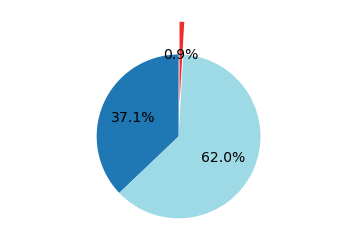

In [25]:

overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent', 'Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [26]:
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)


texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)



sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1

np.unique(sum_texture_right)

array([0, 1, 2, 3])

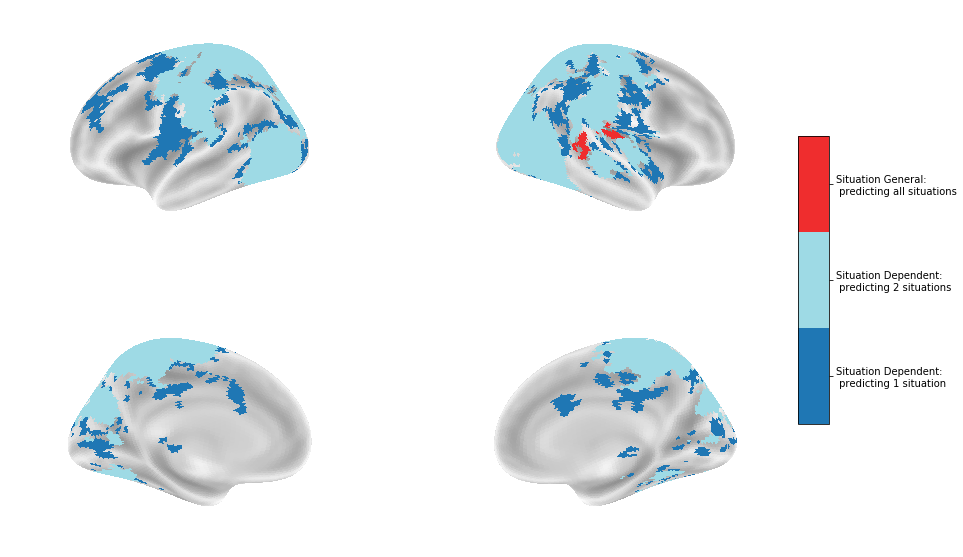

In [27]:
# plot the results:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=-3, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
# cbar_ax.set_yticklabels(["Situation Dependent", "Situation Dependent", "Situation General"])
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


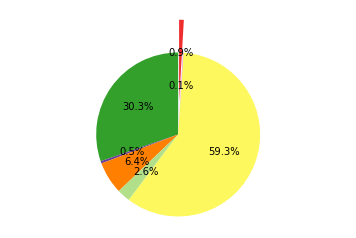

In [28]:
# pie chart - break down by situation:
overlay_by_sit_data = overlay_by_sit.get_fdata()

H_only = np.sum(overlay_by_sit_data==1)
SO_only = np.sum(overlay_by_sit_data==2)
SP_only = np.sum(overlay_by_sit_data==3)
HSO = np.sum(overlay_by_sit_data==4)
HSP = np.sum(overlay_by_sit_data==5)
SOSP = np.sum(overlay_by_sit_data==6)
seven =np.sum(overlay_by_sit_data==7)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = ['Heights Only', 'Social only', 'Spiders only', 'Heights +Social', 'Heights + Spiders', 'Social + Spiders', 'Situation General']
labels = ' ', ' ', ' ', ' ', ' ', ' ', ' '
sizes = [H_only, SO_only, SP_only, HSO, HSP, SOSP, seven]
explode = (0, 0, 0, 0, 0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=my_color_seven)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [29]:
SGH_only =  math_img('img1 == 1', img1 = overlay_by_sit)
SGSO_only =  math_img('img1 == 2', img1 = overlay_by_sit)
SGSP_only =  math_img('img1 == 3', img1 = overlay_by_sit)

SGH_SGSO = math_img('img1==4', img1 = overlay_by_sit)
SGH_SGSP = math_img('img1==5', img1 = overlay_by_sit)
SGSO_SGSP = math_img('img1==6', img1 = overlay_by_sit)

seven = math_img('img1==7', img1 = overlay_by_sit)
texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(SGH_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(SGH_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)

texture_right4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_right, interpolation='nearest')
texture_left4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_left, interpolation='nearest')
texture_right4 = np.where(texture_right4>texture_threshold, 4, 0)
texture_left4 = np.where(texture_left4>texture_threshold, 4, 0)

texture_right5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right5 = np.where(texture_right5>texture_threshold, 5, 0)
texture_left5 = np.where(texture_left5>texture_threshold, 5, 0)

texture_right6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right6 = np.where(texture_right6>texture_threshold, 6, 0)
texture_left6 = np.where(texture_left6>texture_threshold, 6, 0)


texture_right7 = surface.vol_to_surf(seven, fsaverage.pial_right, interpolation='nearest')
texture_left7 = surface.vol_to_surf(seven, fsaverage.pial_left, interpolation='nearest')
texture_right7 = np.where(texture_right7>texture_threshold, 7, 0)
texture_left7 = np.where(texture_left7>texture_threshold, 7, 0)


sum_texture_right = texture_right7 + texture_right6 + texture_right5 + texture_right4 + texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left7 + texture_left6 + texture_left5 + texture_left4 + texture_left3 + texture_left2 + texture_left1

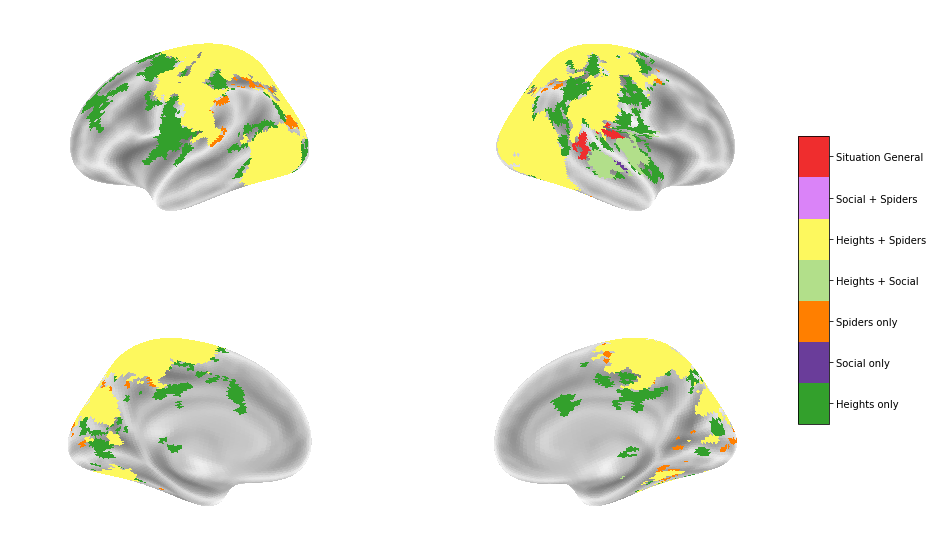

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99, vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=-7, cbar_vmax=7,bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.6, inflate=True)

cmap = matplotlib.colors.ListedColormap(my_color_seven)
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(["Heights only", "Social only", "Spiders only", "Heights + Social", "Heights + Spiders", "Social + Spiders", "Situation General"])
plt.show()

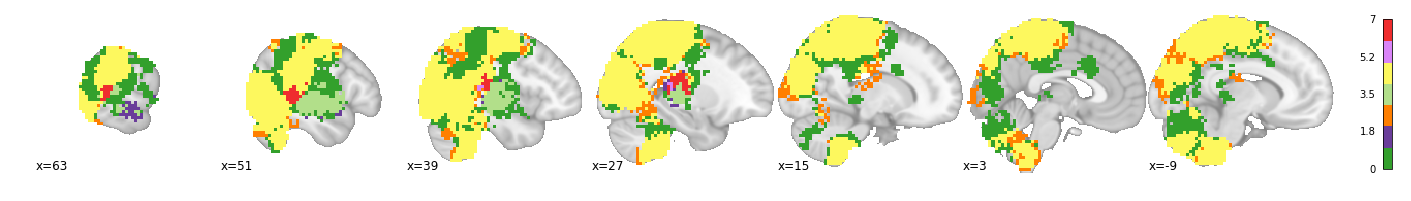

In [31]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)

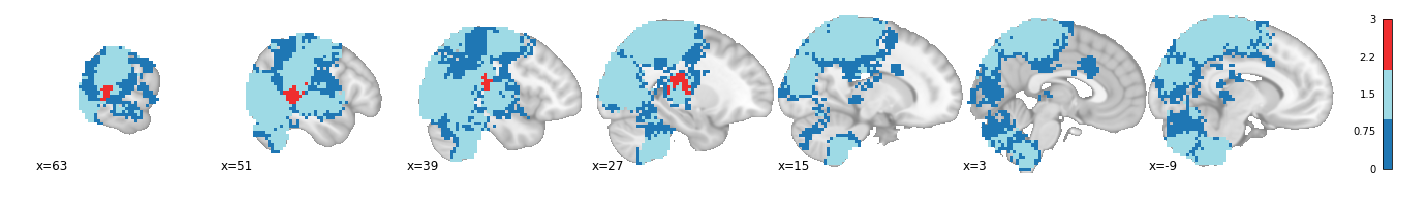

In [32]:
plotting.plot_stat_map(overlay, cmap=my_cmap_three, display_mode='x', vmax=3,bg_img=bg_img,black_bg=False)

# Situation Dependent Model

In [33]:
# overlay by situation-depdent models:
if calculate:
    HH = nib.load(permutation_test_res_dir + f'train_Heights_test_Heights_significant_pearsonr_fwe.nii.gz')
    SOSO = nib.load(permutation_test_res_dir + f'train_Social_test_Social_significant_pearsonr_fwe.nii.gz')
    SPSP = nib.load(permutation_test_res_dir + f'train_Spiders_test_Spiders_significant_pearsonr_fwe.nii.gz')

    HH_mask = math_img('img != 0', img = HH)
    SOSO_mask = math_img('img != 0', img = SOSO)
    SPSP_mask = math_img('img != 0', img = SPSP)

    overlay = math_img('img1 + img2 + img3', img1=HH_mask, img2=SOSO_mask, img3=SPSP_mask)
    nib.save(overlay, permutation_test_res_dir + 'SS_overlay.nii.gz')


    SO_only =  math_img('img * 2', img = SOSO_mask)
    SP_only =  math_img('img * 4', img = SPSP_mask)

    overlay_by_sit = math_img('img1 + img2 + img3', img1=HH_mask, img2=SO_only, img3=SP_only)
    # swtich value 3 and 4 for better visualization:
    overlay_by_sit_data = overlay_by_sit.get_fdata()
    three_idx = np.where(overlay_by_sit_data ==3)
    four_idx = np.where(overlay_by_sit_data ==4)
    overlay_by_sit_data[four_idx] = 3
    overlay_by_sit_data[three_idx] = 4
    overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
    nib.save(overlay_by_sit, permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')
else:
    overlay = nib.load(permutation_test_res_dir + 'SS_overlay.nii.gz')
    overlay_by_sit = nib.load(permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')

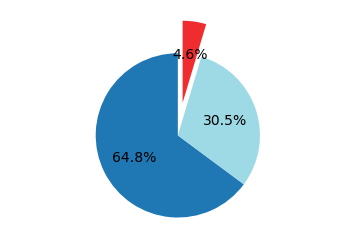

In [34]:
overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent', 'Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

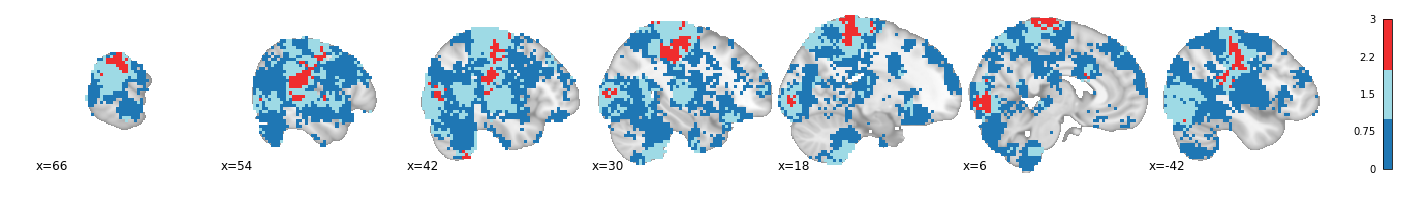

In [35]:
plotting.plot_stat_map(overlay, cmap=my_cmap_three, display_mode='x', vmax=3,bg_img=bg_img,black_bg=False)

In [36]:
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)


texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)



sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1

np.unique(sum_texture_right)

array([0, 1, 2, 3])

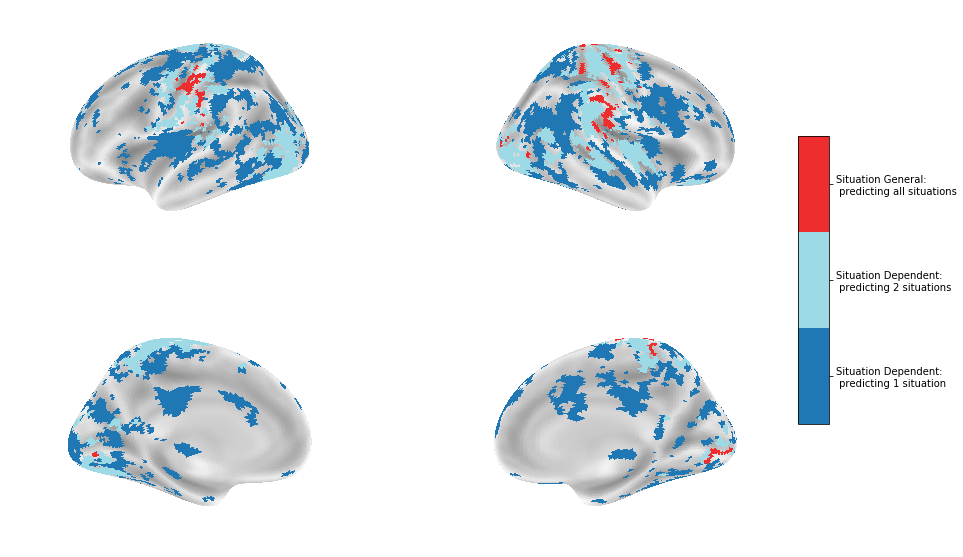

In [37]:
# plot the results:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=-3, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
# cbar_ax.set_yticklabels(["Situation Dependent", "Situation Dependent", "Situation General"])
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


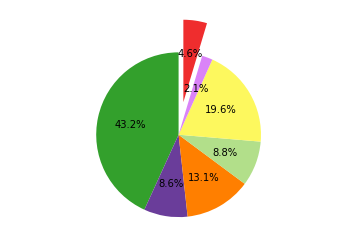

In [38]:
# pie chart - break down by situation:
overlay_by_sit_data = overlay_by_sit.get_fdata()

H_only = np.sum(overlay_by_sit_data==1)
SO_only = np.sum(overlay_by_sit_data==2)
SP_only = np.sum(overlay_by_sit_data==3)
HSO = np.sum(overlay_by_sit_data==4)
HSP = np.sum(overlay_by_sit_data==5)
SOSP = np.sum(overlay_by_sit_data==6)
seven =np.sum(overlay_by_sit_data==7)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = ['Heights Only', 'Social only', 'Spiders only', 'Heights +Social', 'Heights + Spiders', 'Social + Spiders', 'Situation General']
labels = ' ', ' ', ' ', ' ', ' ', ' ', ' '
sizes = [H_only, SO_only, SP_only, HSO, HSP, SOSP, seven]
explode = (0, 0, 0, 0, 0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=my_color_seven)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

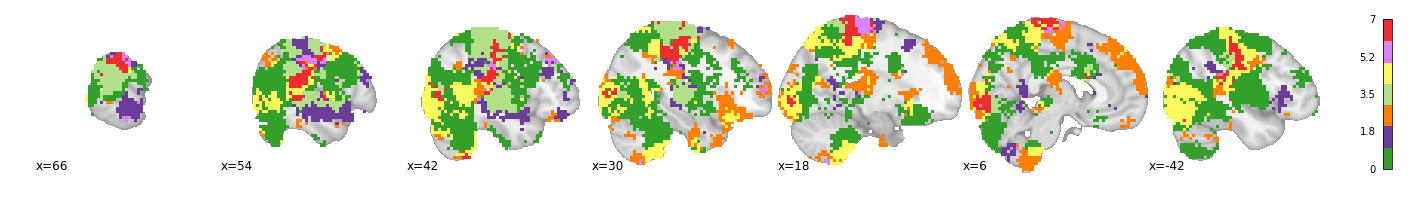

In [39]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)

In [40]:
SGH_only =  math_img('img1 == 1', img1 = overlay_by_sit)
SGSO_only =  math_img('img1 == 2', img1 = overlay_by_sit)
SGSP_only =  math_img('img1 == 3', img1 = overlay_by_sit)

SGH_SGSO = math_img('img1==4', img1 = overlay_by_sit)
SGH_SGSP = math_img('img1==5', img1 = overlay_by_sit)
SGSO_SGSP = math_img('img1==6', img1 = overlay_by_sit)

seven = math_img('img1==7', img1 = overlay_by_sit)
texture_threshold = 0.7

texture_right1 = surface.vol_to_surf(SGH_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(SGH_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)

texture_right4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_right, interpolation='nearest')
texture_left4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_left, interpolation='nearest')
texture_right4 = np.where(texture_right4>texture_threshold, 4, 0)
texture_left4 = np.where(texture_left4>texture_threshold, 4, 0)

texture_right5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right5 = np.where(texture_right5>texture_threshold, 5, 0)
texture_left5 = np.where(texture_left5>texture_threshold, 5, 0)

texture_right6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right6 = np.where(texture_right6>texture_threshold, 6, 0)
texture_left6 = np.where(texture_left6>texture_threshold, 6, 0)


texture_right7 = surface.vol_to_surf(seven, fsaverage.pial_right, interpolation='nearest')
texture_left7 = surface.vol_to_surf(seven, fsaverage.pial_left, interpolation='nearest')
texture_right7 = np.where(texture_right7>texture_threshold, 7, 0)
texture_left7 = np.where(texture_left7>texture_threshold, 7, 0)


sum_texture_right = texture_right7 + texture_right6 + texture_right5 + texture_right4 + texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left7 + texture_left6 + texture_left5 + texture_left4 + texture_left3 + texture_left2 + texture_left1

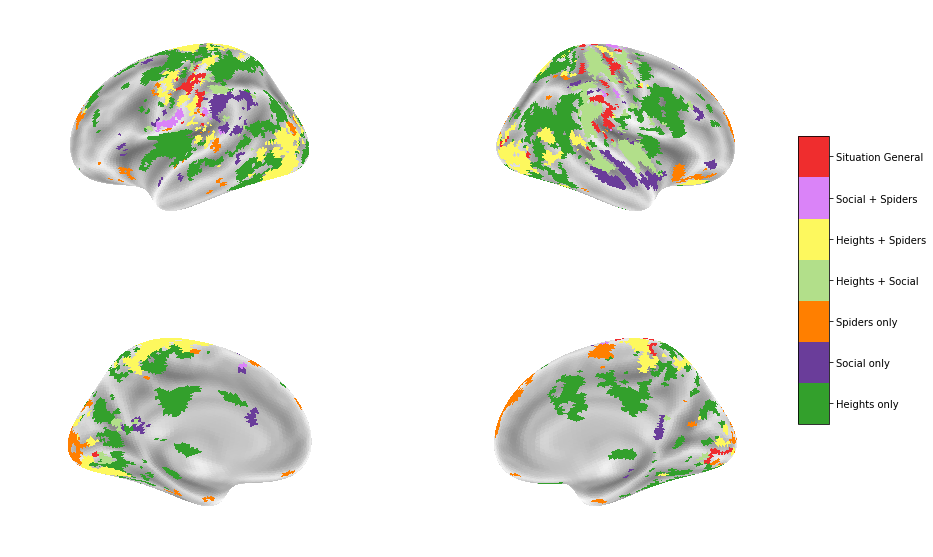

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99, vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=-7, cbar_vmax=7,bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.6, inflate=True)

cmap = matplotlib.colors.ListedColormap(my_color_seven)
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(["Heights only", "Social only", "Spiders only", "Heights + Social", "Heights + Spiders", "Social + Spiders", "Situation General"])
plt.show()

# uncorrected p = 0.05

# Situation General

In [42]:
if calculate:
    permutation_test_res_dir = res_dir + 'permutation_test/'
    SG_H = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Heights_significant_pearsonr.nii.gz')
    SG_SO = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Social_significant_pearsonr.nii.gz')
    SG_SP = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Spiders_significant_pearsonr.nii.gz')
    SG_SG = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Situation_General_significant_pearsonr.nii.gz')


    SG_H_mask = math_img('img != 0', img = SG_H)
    SG_SO_mask = math_img('img != 0', img = SG_SO)
    SG_SP_mask = math_img('img != 0', img = SG_SP)
    SG_SG_mask = math_img('img != 0', img = SG_SG)

    SGSG_SGH = intersect_masks([SG_H_mask, SG_SG_mask],threshold=1)
    SGSG_SGSO = intersect_masks([SG_SO_mask, SG_SG_mask],threshold=1)
    SGSG_SGSP = intersect_masks([SG_SP_mask, SG_SG_mask],threshold=1)

    overlay = math_img('img1 + img2 + img3', img1=SGSG_SGH, img2=SGSG_SGSO, img3=SGSG_SGSP)
    nib.save(overlay, permutation_test_res_dir + 'SGSG_breakdown_overlay_unc05.nii.gz')


    SGSG_SGH = intersect_masks([SG_H_mask, SG_SG_mask],threshold=1)
    SGSG_SGSO = intersect_masks([SG_SO_mask, SG_SG_mask],threshold=1)
    SGSG_SGSP = intersect_masks([SG_SP_mask, SG_SG_mask],threshold=1)

    SGSO_only =  math_img('img * 2', img = SGSG_SGSO)
    SGSP_only =  math_img('img * 4', img = SGSG_SGSP)

    overlay_by_sit = math_img('img1 + img2 + img3', img1=SGSG_SGH, img2=SGSO_only, img3=SGSP_only)
    # swtich value 3 and 4 for better visualization:
    overlay_by_sit_data = overlay_by_sit.get_fdata()
    three_idx = np.where(overlay_by_sit_data ==3)
    four_idx = np.where(overlay_by_sit_data ==4)
    overlay_by_sit_data[four_idx] = 3
    overlay_by_sit_data[three_idx] = 4
    overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
    nib.save(overlay_by_sit, permutation_test_res_dir + 'SGSG_breakdown_overlay_bySit_unc05.nii.gz')
else:
    overlay = nib.load(permutation_test_res_dir + 'SGSG_breakdown_overlay_unc05.nii.gz')
    overlay_by_sit = nib.load(permutation_test_res_dir + 'SGSG_breakdown_overlay_bySit_unc05.nii.gz')

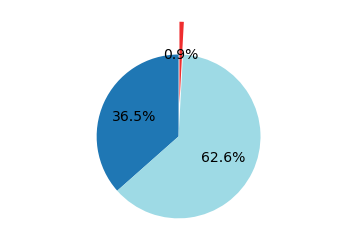

In [43]:

overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent', 'Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [44]:
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)


texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)



sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1

np.unique(sum_texture_right)

array([0, 1, 2, 3])

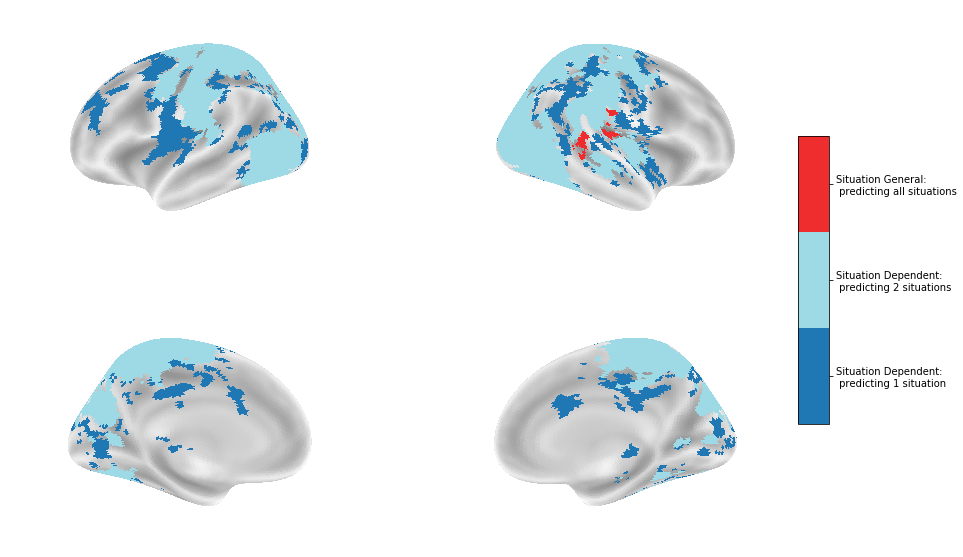

In [45]:
# plot the results:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=-3, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
# cbar_ax.set_yticklabels(["Situation Dependent", "Situation Dependent", "Situation General"])
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


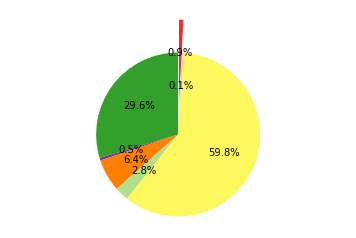

In [46]:
# pie chart - break down by situation:
overlay_by_sit_data = overlay_by_sit.get_fdata()

H_only = np.sum(overlay_by_sit_data==1)
SO_only = np.sum(overlay_by_sit_data==2)
SP_only = np.sum(overlay_by_sit_data==3)
HSO = np.sum(overlay_by_sit_data==4)
HSP = np.sum(overlay_by_sit_data==5)
SOSP = np.sum(overlay_by_sit_data==6)
seven =np.sum(overlay_by_sit_data==7)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = ['Heights Only', 'Social only', 'Spiders only', 'Heights +Social', 'Heights + Spiders', 'Social + Spiders', 'Situation General']
labels = ' ', ' ', ' ', ' ', ' ', ' ', ' '
sizes = [H_only, SO_only, SP_only, HSO, HSP, SOSP, seven]
explode = (0, 0, 0, 0, 0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=my_color_seven)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [47]:
SGH_only =  math_img('img1 == 1', img1 = overlay_by_sit)
SGSO_only =  math_img('img1 == 2', img1 = overlay_by_sit)
SGSP_only =  math_img('img1 == 3', img1 = overlay_by_sit)

SGH_SGSO = math_img('img1==4', img1 = overlay_by_sit)
SGH_SGSP = math_img('img1==5', img1 = overlay_by_sit)
SGSO_SGSP = math_img('img1==6', img1 = overlay_by_sit)

seven = math_img('img1==7', img1 = overlay_by_sit)
texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(SGH_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(SGH_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)

texture_right4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_right, interpolation='nearest')
texture_left4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_left, interpolation='nearest')
texture_right4 = np.where(texture_right4>texture_threshold, 4, 0)
texture_left4 = np.where(texture_left4>texture_threshold, 4, 0)

texture_right5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right5 = np.where(texture_right5>texture_threshold, 5, 0)
texture_left5 = np.where(texture_left5>texture_threshold, 5, 0)

texture_right6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right6 = np.where(texture_right6>texture_threshold, 6, 0)
texture_left6 = np.where(texture_left6>texture_threshold, 6, 0)


texture_right7 = surface.vol_to_surf(seven, fsaverage.pial_right, interpolation='nearest')
texture_left7 = surface.vol_to_surf(seven, fsaverage.pial_left, interpolation='nearest')
texture_right7 = np.where(texture_right7>texture_threshold, 7, 0)
texture_left7 = np.where(texture_left7>texture_threshold, 7, 0)


sum_texture_right = texture_right7 + texture_right6 + texture_right5 + texture_right4 + texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left7 + texture_left6 + texture_left5 + texture_left4 + texture_left3 + texture_left2 + texture_left1

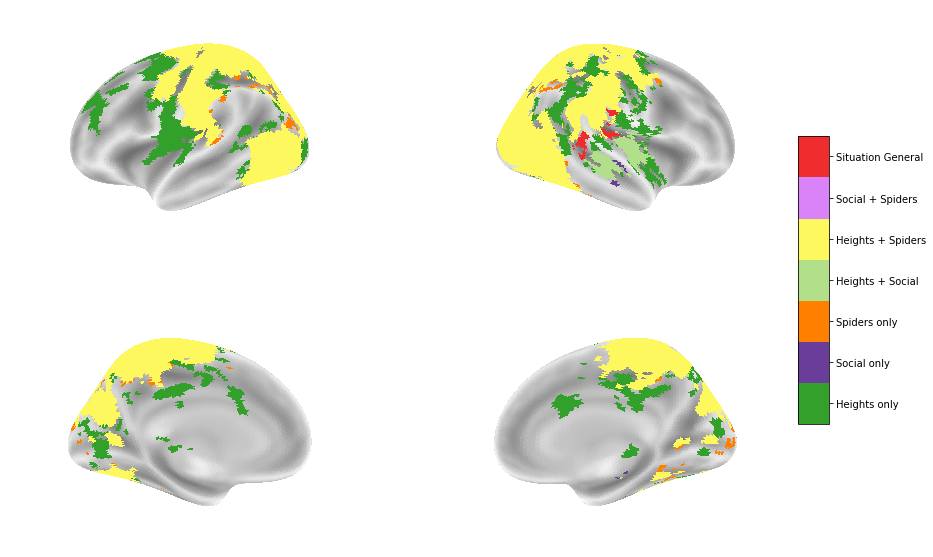

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99, vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=-7, cbar_vmax=7,bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.6, inflate=True)

cmap = matplotlib.colors.ListedColormap(my_color_seven)
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(["Heights only", "Social only", "Spiders only", "Heights + Social", "Heights + Spiders", "Social + Spiders", "Situation General"])
plt.show()

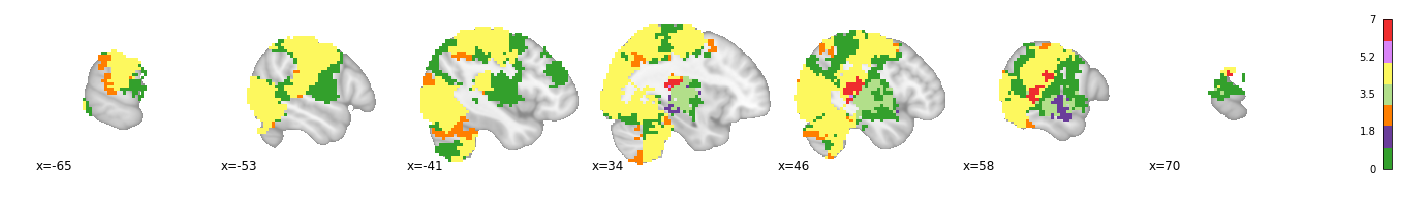

In [49]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)

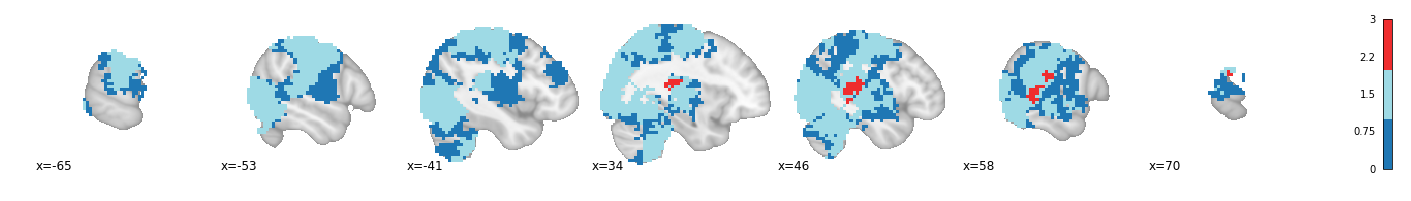

In [50]:
plotting.plot_stat_map(overlay, cmap=my_cmap_three, display_mode='x', vmax=3,bg_img=bg_img,black_bg=False)

# Situation Dependent Model

In [51]:
# overlay by situation-depdent models:
if calculate:
    HH = nib.load(permutation_test_res_dir + f'train_Heights_test_Heights_significant_pearsonr.nii.gz')
    SOSO = nib.load(permutation_test_res_dir + f'train_Social_test_Social_significant_pearsonr.nii.gz')
    SPSP = nib.load(permutation_test_res_dir + f'train_Spiders_test_Spiders_significant_pearsonr.nii.gz')

    HH_mask = math_img('img != 0', img = HH)
    SOSO_mask = math_img('img != 0', img = SOSO)
    SPSP_mask = math_img('img != 0', img = SPSP)

    overlay = math_img('img1 + img2 + img3', img1=HH_mask, img2=SOSO_mask, img3=SPSP_mask)
    nib.save(overlay, permutation_test_res_dir + 'SS_overlay.nii.gz')


    SO_only =  math_img('img * 2', img = SOSO_mask)
    SP_only =  math_img('img * 4', img = SPSP_mask)

    overlay_by_sit = math_img('img1 + img2 + img3', img1=HH_mask, img2=SO_only, img3=SP_only)
    # swtich value 3 and 4 for better visualization:
    overlay_by_sit_data = overlay_by_sit.get_fdata()
    three_idx = np.where(overlay_by_sit_data ==3)
    four_idx = np.where(overlay_by_sit_data ==4)
    overlay_by_sit_data[four_idx] = 3
    overlay_by_sit_data[three_idx] = 4
    overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
    nib.save(overlay_by_sit, permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')
else:
    overlay = nib.load(permutation_test_res_dir + 'SS_overlay.nii.gz')
    overlay_by_sit = nib.load(permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')

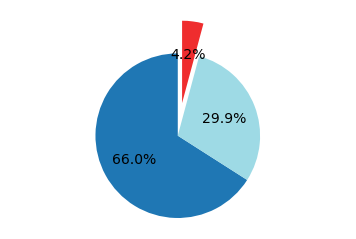

In [52]:
overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent', 'Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [53]:
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)


texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)



sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1

np.unique(sum_texture_right)

array([0, 1, 2, 3])

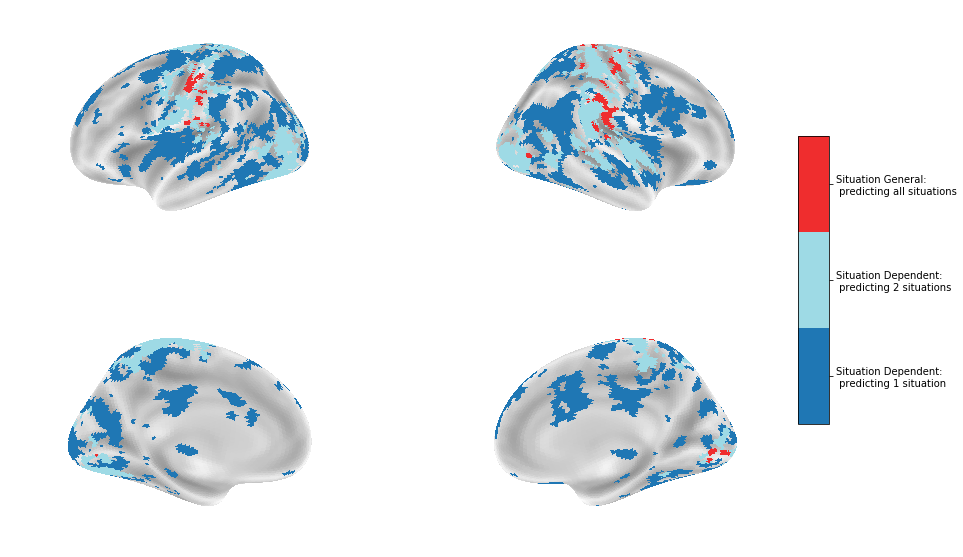

In [54]:
# plot the results:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=-3, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
# cbar_ax.set_yticklabels(["Situation Dependent", "Situation Dependent", "Situation General"])
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


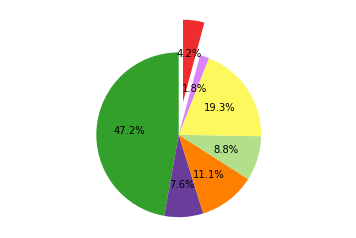

In [55]:
# pie chart - break down by situation:
overlay_by_sit_data = overlay_by_sit.get_fdata()

H_only = np.sum(overlay_by_sit_data==1)
SO_only = np.sum(overlay_by_sit_data==2)
SP_only = np.sum(overlay_by_sit_data==3)
HSO = np.sum(overlay_by_sit_data==4)
HSP = np.sum(overlay_by_sit_data==5)
SOSP = np.sum(overlay_by_sit_data==6)
seven =np.sum(overlay_by_sit_data==7)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = ['Heights Only', 'Social only', 'Spiders only', 'Heights +Social', 'Heights + Spiders', 'Social + Spiders', 'Situation General']
labels = ' ', ' ', ' ', ' ', ' ', ' ', ' '
sizes = [H_only, SO_only, SP_only, HSO, HSP, SOSP, seven]
explode = (0, 0, 0, 0, 0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=my_color_seven)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [56]:
SGH_only =  math_img('img1 == 1', img1 = overlay_by_sit)
SGSO_only =  math_img('img1 == 2', img1 = overlay_by_sit)
SGSP_only =  math_img('img1 == 3', img1 = overlay_by_sit)

SGH_SGSO = math_img('img1==4', img1 = overlay_by_sit)
SGH_SGSP = math_img('img1==5', img1 = overlay_by_sit)
SGSO_SGSP = math_img('img1==6', img1 = overlay_by_sit)

seven = math_img('img1==7', img1 = overlay_by_sit)
texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(SGH_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(SGH_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(SGSO_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(SGSP_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)

texture_right4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_right, interpolation='nearest')
texture_left4 = surface.vol_to_surf(SGH_SGSO, fsaverage.pial_left, interpolation='nearest')
texture_right4 = np.where(texture_right4>texture_threshold, 4, 0)
texture_left4 = np.where(texture_left4>texture_threshold, 4, 0)

texture_right5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left5 = surface.vol_to_surf(SGH_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right5 = np.where(texture_right5>texture_threshold, 5, 0)
texture_left5 = np.where(texture_left5>texture_threshold, 5, 0)

texture_right6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_right, interpolation='nearest')
texture_left6 = surface.vol_to_surf(SGSO_SGSP, fsaverage.pial_left, interpolation='nearest')
texture_right6 = np.where(texture_right6>texture_threshold, 6, 0)
texture_left6 = np.where(texture_left6>texture_threshold, 6, 0)


texture_right7 = surface.vol_to_surf(seven, fsaverage.pial_right, interpolation='nearest')
texture_left7 = surface.vol_to_surf(seven, fsaverage.pial_left, interpolation='nearest')
texture_right7 = np.where(texture_right7>texture_threshold, 7, 0)
texture_left7 = np.where(texture_left7>texture_threshold, 7, 0)


sum_texture_right = texture_right7 + texture_right6 + texture_right5 + texture_right4 + texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left7 + texture_left6 + texture_left5 + texture_left4 + texture_left3 + texture_left2 + texture_left1

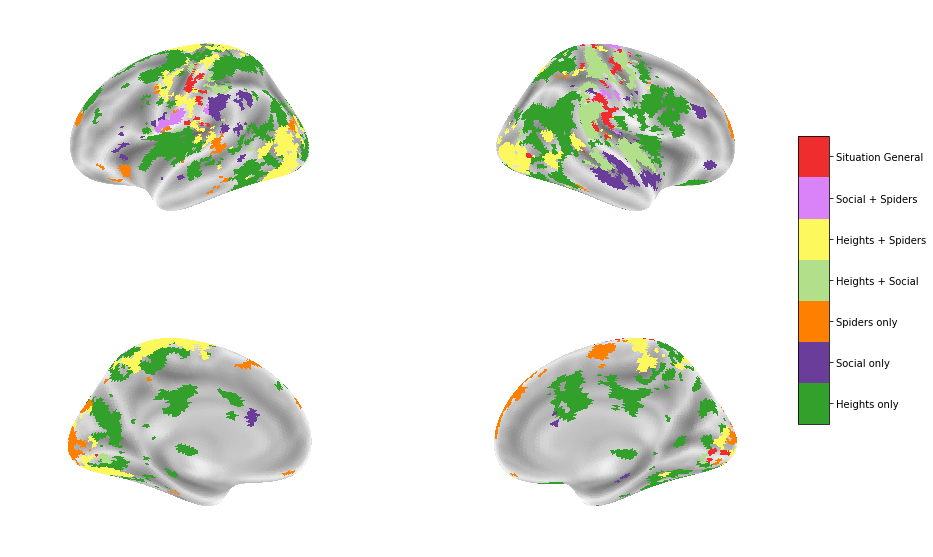

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99,vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=0, cbar_vmax=7,bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.6, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_seven, threshold=0.99, vmax =7,vmin=-7,avg_method='median',
                            cbar_vmin=-7, cbar_vmax=7,bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.6, inflate=True)

cmap = matplotlib.colors.ListedColormap(my_color_seven)
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(["Heights only", "Social only", "Spiders only", "Heights + Social", "Heights + Spiders", "Social + Spiders", "Situation General"])
plt.show()

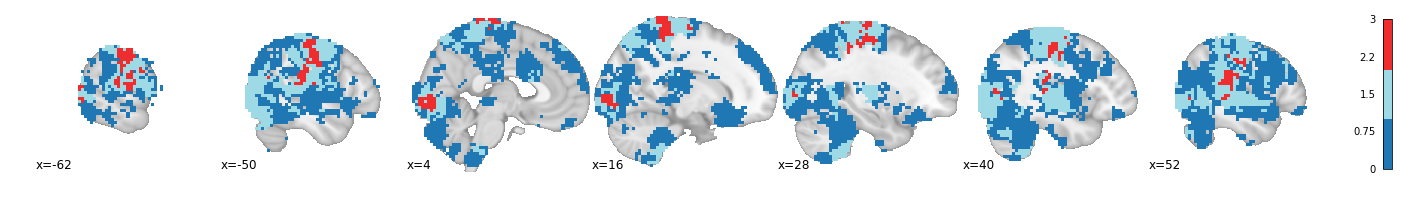

In [58]:
plotting.plot_stat_map(overlay, cmap=my_cmap_three, display_mode='x', vmax=3,bg_img=bg_img,black_bg=False)

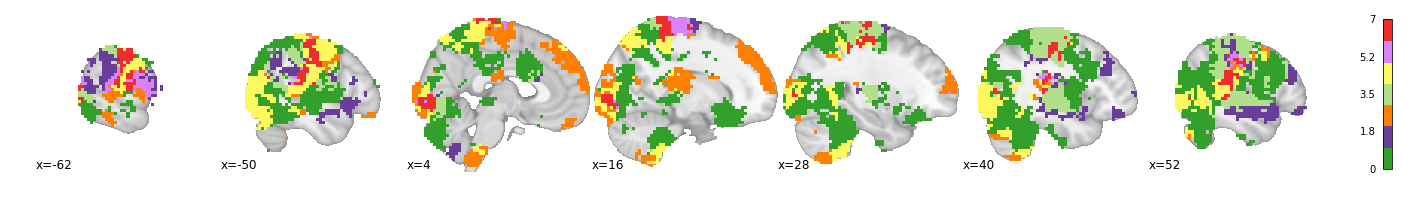

In [59]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)